In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint

In [8]:
def sir(variables, t, beta, gamma):
    S = variables[0]
    I = variables[1]
    R = variables[2]

    N = S + I + R

    dSdt = -beta * I * S / N
    dIdt = beta * I * S / N - gamma * I
    dRdt = gamma * I

    return([dSdt, dIdt, dRdt])

In [9]:
S = [200]
I = [1]
R = [0]
t = [0]

tend = 500

beta = 0.04
gamma = 0.01

In [10]:
while t[-1] < tend and (S[-1] + I[-1] >= 1):
	# Get Population
    N = S[-1] + I[-1] + R[-1]

	# Get the probablities: [S -> I, I -> R]
    props = [beta*I[-1]*S[-1]/N, gamma*I[-1]]

	# Get sum of probability
    prop_sum = sum(props)

	# Determine the time until the next event occurs based on the probabilty sum.
    tau = np.random.exponential(scale=1/prop_sum)
    t.append(t[-1]+tau) 

    # Generate random number    
    rand = random.uniform(0,1)

    # See if Susceptible becomes Infected
    if rand * prop_sum <= props[0]:
            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])

    # Else, Infected becomes Recovered
    else:
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1) 

In [11]:
y0 = [200, 1, 0]
y = odeint(sir, y0, t, args=(beta, gamma))

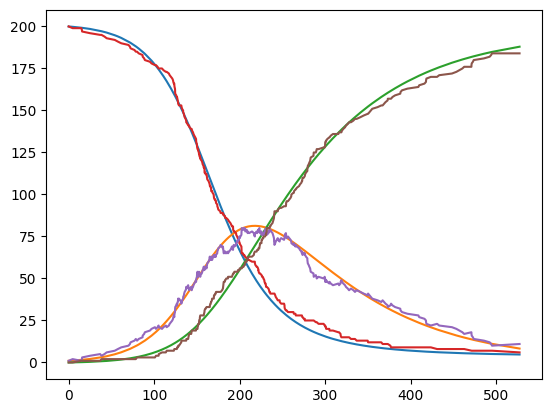

In [12]:
# plot the results

plt.plot(t,y[:,0]) # S
plt.plot(t,y[:,1]) # I
plt.plot(t,y[:,2]) # R

plt.plot(t, S)
plt.plot(t, I)
plt.plot(t, R)


plt.show()